(sec:deep-learning)=
# 深層学習による画像識別

前回、[特徴量抽出](sec:feature-extraction)では、画像から特徴量を検出し、それを画像識別に利用する方法を見てきた。

2000年台まで、画像識別の分野では、**画像を如何に特徴化するか**と**得られた特徴からどのように物体を認識するか**という二つの研究が中心となってきた。

そのために、SIFTを始めとする特徴量の改善や、カーネル法を用いたSVMの性能改善などが試みられてきたが、その性能は徐々に頭打ちになっていく。

そんな折、彗星のごとく現れた技術がニューラルネットワークを多層化した深層学習である。実は、ニューラルネット自体は人間の脳のシナプス同士の結合を模したモデルとして1950年代から研究されていた。

最初にニューラルネットが日の目を見たのは1980年代で、この頃には、入力層、隠れ層、出力層の三層を持つニューラルネットがある程度の性能を出せることが知られていた。当然ながら、その当時も、より多層のニューラルネットワークを利用しようという考え自体はあり、検討が試みられたが、ニューラルネットワークの持つ多数のパラメータを上手く最適化する手法がなく、その時代には実現が難しいと考えられていた。

なお、多層のニューラルネットの考え方を最初に提唱したのは、当時NHKの放送技術研究所の研究員であった福島邦彦氏であるとされており、その論文は、驚くべきことに1980年に出版されている {cite}`fukushima1980neocognitron`。方向性は異なるものの、これは2024年にノーベル物理学賞を獲得したJeffery Hinton氏の代表研究である誤差逆伝搬の論文{cite}`rumelhart1986learning`や、John Hopfield氏のHopfieldネットワーク{cite}`hopfield1982neural`の論文よりも前の研究である。

2010年代に入ると、それまで下火だったニューラルネットが再び注目を集めることになる。それまで細々と続けられていたニューラルネットワークの研究の中で、パラメータの過学習や、最適化時の勾配消失といった問題が徐々に解決されるとともに、GPUを用いた汎用計算であるGPGPU (General Purpose Computing on GPU)により並列計算の公立が大幅に上昇するなど、ニューラルネットワークを取り巻く環境が徐々に変化してくる。

そして、2012年に深層学習を一躍有名にする出来事が起こる。

ImageNetと呼ばれる大規模画像データセットの識別チャレンジであるILSVRC (ImageNet Large Scale Visual Recognition Challenge)において、トロント大学のGeoffrey Hintonらの研究チームが、AlexNet (筆頭著者のfirst nameから)と呼ばれる二股のニューラルネットを用いて、2位のエラー率26.2%に大差をつけ、エラー率わずか17.0％を達成し、優勝する {cite}`krizhevsky2012imagenet`。この時の2位のチーム(東京大学のチーム)が用いた手法はSIFT, Fisher Vector, SVMを組み合わせたものであった。

この優勝を皮切りに、2013年の大会ではオックスフォード大学のチームがVGGというネットワークで2位に入り、以後、2014年はGoogleのチームがGoogLeNetというネットワークで2位、2015年はMicrosoftのチームがResNetというネットワークで優勝する。

こうして、2016年くらいになると、現在のニューラルネットワークの構築において一般的になっている諸技術、例えば、

- Rectified Linear Unit (ReLU)
- Max Pooling
- Dropout
- Batch Normalization
- Skip Connection (Residual Block)
- Adaptive Momentum Estimation (Adam)

などの技術が、一通り出そろう。

さらには、この頃になるとNVIDIAのCaffeや、モントリオール大学のtheano、FacebookのTorch、そしてPreferred NetworkのChainerといった汎用の深層学習用ライブラリが多数登場する。これによって、深層学習の研究が一気に花開き、現在に至る。

**Google Colab用の準備**

In [1]:
IN_COLAB = True
try:
    import google.colab

    print("You are running the code in Google Colab.")
except:
    IN_COLAB = False
    print("You are running the code in the local computer.")

if IN_COLAB:
    # PyTorchのインストール
    !pip install myst-nb
    !pip install torch torchvision torchaudio
    pass

You are running the code in the local computer.


In [2]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: _

# 実験に使うサンプル数
epochs = 5
batch_size = 32
glue("epochs", epochs, display=False)
glue("batch_size", batch_size, display=False)

# グラフの設定
rc = {"figure.dpi": 150}
sns.set_theme(style="white", palette="colorblind", rc=rc)
color_palette = sns.color_palette("colorblind")

**平仮名データセットの準備**

In [3]:
import zipfile

import requests

url = "http://lab.ndl.go.jp/dataset/hiragana73.zip"
filename = os.path.basename(url)

# HTTPリクエストを送ってデータサイズを取得
r = requests.get(url, stream=True)
total_size = int(r.headers.get("content-length", 0))
chunk_size = 65535

# "hiragana73"フォルダが存在し、その中身が空でないことを確認
if not os.path.exists("./hiragana73") or len(os.listdir("./hiragana73")) == 0:
    # 実際のファイルのダウンロード
    pbar = tqdm(total=total_size, unit="B", unit_scale=True)
    with open(filename, "wb") as f:
        for data in r.iter_content(chunk_size):
            f.write(data)
            pbar.update(chunk_size)

    # ダウンロードが完了したらZIPを展開する
    with zipfile.ZipFile(filename, "r") as f:
        f.extractall()

## PyTorchの基本

本項では、数ある深層学習のフレームワークのうち、研究開発目的に最も一般的に使用されていると思われるPyTorchを扱う。

PyTorchには、いくつかのモジュールが用意されており、代表的なものが、

- `torch`
- `torch.nn`
- `torch.nn.functional`

の3つである。慣例的に、これらをこのような形でエイリアスを与えてインポートする。

In [4]:
# PyTorchのモジュール群
import torch
import torch.nn as nn
import torch.nn.functional as F

`torch`モジュールがテンソルデータそのもの(`torch.Tensor`等)や、データに対する操作 (`torch.exp`や`torch.transpose`等)が含まれる。

`torch.nn`モジュールには、ニューラルネットワークを構成するレイヤー (`nn.Linear`や`nn.Conv2d`等)や損失関数 (`nn.CrossEntropyLoss`や`nn.MSELoss`等)が含まれる。

`torch.nn.functional`モジュールには、`torch.nn`モジュールに含まれるクラス定義に対応する関数が用意されている。例えば`nn.Linear`に対応する関数として`F.linear`、`nn.MSELoss`に対応する関数として`F.mse_loss`、といった具合である。

また、インストールすることは必須ではないが、PyTorchに付属するライブラリにTorchVisionがある。TorchVisionは、主にコンピュータ・ビジョンへの応用を目的とした補助関数が多数用意されている。

これ以外にも、有名ネットワークモデルの学習済み重みなどが提供されており、`AlexNet`や`ResNet50`等のほか、`ViT`などの比較的新しいものも含まれている。

本資料では、画像の前処理に使う`transforms`モジュールだけを用いる (使用方法については後述する)。

### torch.Tensor

PyTorchの中で変数を扱う場合、スカラーであってもベクトルであっても、はたまた行列であっても、共通で`torch.Tensor`という型を用いる。これは、NumPyの`np.array`とほとんど同じように使うことができる。

初期化をする方法には、いくつかあるが、大きく分けて、

- `torch.Tensor`のコンストラクタを呼び出す
- `torch.tensor`関数を用いて`Tensor`を作る
- NumPyの配列を最初に用意して`torch.from_numpy`関数を使う

の3つの方法がある。順に見ていこう。

#### torch.Tensorを使う

まず、`torch.Tensor`型のコンストラクタを用いて初期化する場合を見ていく。この場合、コンストラクタの引数にPythonやNumPyの配列を指定して初期化する。

この時、配列がどのような型であっても、PyTorchの`default_dtype`に指定された型 (初期値は`float32`)の型にキャストされる。

In [6]:
x_npy = np.arange(10)
print("NumPy's dtype:", x_npy.dtype)
x = torch.Tensor(x_npy)
print("Torch's dtype:", x.dtype)

NumPy's dtype: int32
Torch's dtype: torch.float32


このように、NumPyの配列としての型は`int64`型であるにも関わらず、`torch.Tensor`を用いることで、型が`float32`に変更されていることが分かる。なお、この初期の型は`torch.set_default_dtyoe`で変更することもできる。

In [7]:
# 初期の型を64bit浮動小数に変更
torch.set_default_dtype(torch.float64)
x = torch.Tensor(x_npy)
print("Torch's dtype:", x.dtype)

# 元に戻しておく
torch.set_default_dtype(torch.float32)

Torch's dtype: torch.float64


#### torch.tensorを使う

次に`torch.Tensor`型のインスタンスを作成する関数である`torch.tensor`を用いる場合を見ていく。

本関数は`torch.Tensor`と関数が似ており、非常に紛らわしいが、`torch.Tensor`はコンストラクタであり、`torch.tensor`は初期化用のユーティリティ関数である。

使い方も非常に似ており、`torch.tensor`にも、PythonやNumPyの配列を指定して`torch.Tensor`型の多次元配列を作ることができる。

In [8]:
x_npy = np.arange(10)
x = torch.tensor(x_npy)
print("Torch's dtype:", x.dtype)

Torch's dtype: torch.int32


`torch.tensor`は先ほどとは異なり、PythonやNumPyの配列で定義されている要素の型を引き継ぐ。そのため、上記の例では`torch.Tensor`の`dtype`が`int64`になっている。また、`torch.tensor`関数は、型を指定して`torch.Tensor`を作ることもできる。

In [9]:
x = torch.tensor(x_npy, dtype=torch.float32)
print("Torch's dtype:", x.dtype)

Torch's dtype: torch.float32


また、詳細については後述するが、PyTorchの自動微分の機能を使うために必要な`requires_grad`パラメータを指定することもできる。

In [10]:
x = torch.tensor(x_npy, dtype=torch.float32, requires_grad=True)
print(x)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], requires_grad=True)


このように`torch.tensor`関数は`torch.Tensor`のコンストラクタを呼び出す場合と比べて圧倒的に使い勝手が良い。

従って、プログラマ自身が型を管理することに抵抗がないのであれば、`torch.tensor`関数を使うのが良いだろう。

#### torch.from_numpy

最後にNumPyの配列から`torch.Tensor`型のインスタンスを作成する`torch.from_numpy`を用いる場合を見ていく。

`torch.from_numpy`関数も`torch.Tensor`と仕様はかなり似ているが、

- 引数としてNumPyの配列しか取ることができない
- `dtype`はNumPyのものを引き継ぐ

の2点が大きく異なる。 

In [11]:
x_npy = np.arange(10)
x = torch.from_numpy(x_npy)
print("Torch's dtype:", x.dtype)

Torch's dtype: torch.int32


また`torch.from_numpy`は元のNumPyの配列とデータを共有しており、**元の配列の値を書き換えるとそれが反映される**という違いがある。

In [12]:
# torch.Tensorの場合
x_npy = np.arange(10)
x = torch.Tensor(x_npy)
print("Before:", x)
x_npy *= 2
print(" After:", x)

Before: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
 After: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


In [13]:
# torch.from_numpyの場合
x_npy = np.arange(10)
x = torch.from_numpy(x_npy)
print("Before:", x)
x_npy *= 2
print(" After:", x)

Before: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)
 After: tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18], dtype=torch.int32)


この違いを意識すべき場面は少ないが、時に問題が生じることがあるので、特段の理由がない限りは`torch.tensor`を使う方が、多くの場合で問題を引き起こす危険性が低いだろう。

### torch.Tensorからの値の取り出し

また`torch.Tensor`型で何らかの演算を行った後で、それをPythonやNumPyの配列に戻したいと思うこともあるだろう。この場合には、Pythonの配列なら`tolist`関数、NumPyの配列なら`numpy`関数を用いる。

In [14]:
x = torch.arange(10)

# Pythonの配列に直す
x_list = x.tolist()
print("Type:", type(x_list))
print(x_list)

# NumPyの配列に直す
x_npy = x.numpy()
print("Type:", type(x_npy))
print(x_npy)

Type: <class 'list'>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Type: <class 'numpy.ndarray'>
[0 1 2 3 4 5 6 7 8 9]


また、配列の値が1つである場合に限り、`item`関数を使って、その1つの値をPythonの数値型として取り出すこともできる。この`item`関数は、要素が2つ以上ある配列に対して呼び出すと例外が発生するので注意すること。

In [15]:
x = torch.tensor([1.0], dtype=torch.float32)
print(x.item())

1.0


## 自動微分

深層学習を支える重要な技術に**自動微分**がある。関数の微分は、損失関数の最小化といった最適化問題にとって重要な情報であり、例えば、最急降下法やニュートン法といったアルゴリズムは、それぞれ関数の1階微分 (勾配)と、2階微分 (Hesse行列)を用いる。

しかし、このような微分を求めるには、数学的に関数の微分を求めておく必要があり、特に関数が複雑な場合には、それを求めることは困難である (従来はMathematicaなどのソフトを使って、勾配を求めるコードを書き出していた)。

また、1階微分であれば、差分法によって近似をすることも可能ではあるが、数値精度の問題は残る。2階微分以上になると差分計算の誤差が蓄積していくため、数値的に満足な結果を得ることは非常に難しくなる。

### 自動微分の仕組み

**自動微分**は、プログラム的に、とある演算とその微分計算がペアとして定義されており、演算の列によって表される関数の微分は、各演算の微分から、合成関数の微分としての連鎖率 (chain rule)により計算される。

一例として、ここでは、

$$
f(x) = \cos(x^2)
$$

の微分を例にとって見てみよう。

ここで、$g(x) = x^2$, $h(x) = \cos x$とすると、$f$は$g$と$h$の合成関数として$f = h \circ g$と表せる。言うまでもなく、$f$の微分$f'$は、$h$と$g$の微分を用いて、

$$
\begin{aligned}
f'(x) &= \frac{\text{d}f}{\text{d}x} = \frac{\text{d}h}{\text{d}g} \frac{\text{d}g}{\text{d}x} \\
&= -\sin (g(x)) \cdot 2 x \\
&= -2x \sin (x^2)
\end{aligned}
$$

となる。ここで注目してほしいのは、$f(x)$を計算する際の計算順序が、

1. $x$の値が与えられる
2. $y = x^2$の値を計算する
3. $z = \cos(y)$の値を計算する

となっているということである。導関数$f$の微分を計算するときには、この逆順に、

1. $z$の$z$に関する微分として$\text{d}z/\text{d}z=1$が与えられる
2. 既知の$y$から$\text{d}z/\text{d}y = (\text{d}z/\text{d}z) \cdot (\text{d}z/\text{d}y) = 1 \cdot (-\sin(y)) = -\sin(y)$を計算する
3. 既知の$x$から$\text{d}z/\text{d}x = (\text{d}z/\text{d}y) \cdot (\text{d}y/ \text{d}x) = (-\sin(y)) \cdot (2 x) = -2x \sin(x^2)$を計算する

という流れになっている。従って、各演算$y=f(x)$において、

- 演算の入力$x$を保持しておく
- 演算の導関数$\text{d}y/\text{d}x$を定義しておく

という準備をしておけば、最終出力$z$の$y$に関する微分$\text{d}z/\text{d}y$が与えられれば、連鎖率を用いて$\text{d}z/\text{d}x$が求まる、という訳である。

### 自動微分の利用

では、上記の議論をPyTorchを用いて実験してみる。前述の通り、`torch.tensor`関数に`requires_grad`パラメータを指定することで、**自動微分により勾配が計算される変数**を作ることができる。

In [16]:
# 変数を作成
x = torch.tensor([2.0], requires_grad=True)

なお、一度、作成した`Tensor`に対して自動微分を有効にしたい場合には`requires_grad_`関数に`True`を渡す。

In [17]:
x = x.requires_grad_(True)

それでは、ここで定義した$x$を用いて変数を用いて、$z = \cos(x^2)$を段階的に計算してみる。

In [18]:
# y = g(x) = x^2の計算
y = x * x
print(f"y = g(x) = {y.item():.1f}")

# z = cos(y)の計算
z = torch.cos(y)
print(f"z = h(y) = {z.item():.5f}")

y = g(x) = 4.0
z = h(y) = -0.65364


最終的な$z$の$x$に関する微分を求めるには、`z.backward()`という関数を呼び出せば良い。ただし、この関数は**スカラーの出力にしか使えない**ので注意が必要。

In [19]:
# 微分の計算
z.backward()

すると、予め自動微分を有効にしておいた変数には`grad`というメンバが追加され、そこに微分の値が代入される。**なお、`backward`関数は、デフォルトでは、一度呼び出すと同じ変数に対して再度呼び出すことはできないようになっている(メモリをできるだけ削減するため)**。

同じ関数に対して、何度も`backward`を呼び出したい場合には、`backward`関数のパラメータに`retain_graph=True`を渡すこと (例外のメッセージにも同様のことが書かれている)。

In [20]:
try:
    z.backward()
except Exception as e:
    print("Exception:", e)

Exception: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


In [21]:
dzdx_autograd = x.grad
print(f"autograd: dz/dx = {dzdx_autograd.item():.5f}")

dzdx_analytic = -2.0 * x * torch.sin(x * x)
print(f"analytic: dz/dx = {dzdx_analytic.item():.5f}")

autograd: dz/dx = 3.02721
analytic: dz/dx = 3.02721


以上から、自動微分によって、正しく演算の微分が計算できていることが確認できた。

上記と同等の計算は、単に入力となっている$x$に関する勾配を求めたいだけであれば `torch.autograd.grad`を用いて、以下のように書くこともできる。なお、`torch.autograd.grad`関数の戻り値は、配列になっているので注意すること。

In [22]:
x = torch.tensor([2.0], requires_grad=True)
z = torch.cos(x * x)
dzdx = torch.autograd.grad(z, inputs=x)
print(f"autograd.grad: dz/dz = {dzdx[0].item():.5f}")

autograd.grad: dz/dz = 3.02721


::::{admonition} 計算グラフ
:class: important

上記の計算では、 $y = x^2$, $z = \cos(y)$ として、連鎖律を用いて微分の計算を行った。このように、「ある計算の結果」を「次の計算で用いる」というような、計算の繋がりによって作られるグラフ構造のことを**計算グラフ**と呼ぶ。通常、四則演算や関数の計算などの多くの計算は単項演算 (変数1つに対して行われる演算、 $x^2$ や $\cos(x)$ など)と二項演算 (変数2つに対して行われる演算、 $x + y$ や $x^y$ など)に分けられ、3つ以上の変数が絡む演算も基本的には単項演算と二項演算の組み合わせによって表現できる。

自動微分においては、計算の過程でこのような計算グラフをライブラリが内部的に構築しており、グラフを遡っていくことで、「最終的な出力」の「グラフ中に現れた変数」に関する微分を計算している。PyTorchの`backward`等の関数に渡せるパラメータの中にも`retain_graph`や`create_graph`など、「グラフ」という言葉を含むものがあるのはこのためである。
::::

### 自動微分可能な演算の定義

PyTorchを使うと、自分で微分可能な演算を定義することもできる。関数を定義するための一般的な方法は、`torch.autograd.Function`を継承したクラスを定義し、そこに静的メソッドとして`forward`と`backward`の二つの関数を実装するというものである。

`forward`内で計算済みの変数で、`backward`の計算でも使うものは`ctx.save_for_backward(...)`を用いて`backward`関数に渡すことができる。変数の取り出しには`ctx.saved_tensors`を用いる。以下の例では、$\cos(x)$を例にとって、実際に微分可能な演算を定義してみる。

In [23]:
from torch.autograd import Function


class MyCosine(Function):
    @staticmethod
    def forward(ctx, x):
        y = torch.cos(x)
        ctx.save_for_backward(x, y)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x, y = ctx.saved_tensors
        return grad_output * (-torch.sin(x))

この実装では、`forward`の中で、$y = \cos(x)$として、戻り値を計算した後に、入力の$x$と出力の$y$の値を`save_for_backward(x, y)`として`backward`側でも使えるようにしている。今回の計算では、$\cos(x)$の微分が$-\sin(x)$であるため、必ずしも$y$を`backward`側で使えるようにしておく必要はない。しかし、例えば$\exp(x)$やシグモイド関数$1 / (1 + \exp(x))$のように、導関数のなかに自分自身を含むようなものも多く、計算量の観点から、`forward`での出力を`backward`側で使えるようにしておくことが多い。

この`Function`型のサブクラスは`MyCosine.apply`のように呼び出すことで関数の`forward`が呼び出されて、その計算結果が使われた出力において`backward`が呼び出されると、自動的に`MyCosine`の`backward`のその計算の中で呼び出されるようになる。

PyTorch内部の実装においては、上記のような`Function`のサブクラスを内部で呼び出すような関数を定義している場合が多く、それに従って`my_cos`関数を定義しておく。

In [24]:
def my_cos(x):
    return MyCosine.apply(x)

これを用いて、再度 $\cos(x^2)$の微分を計算してみると、以下のように正しく計算が行えていることが分かる。

In [25]:
x = torch.tensor([2.0], requires_grad=True)
y = x * x
z = my_cos(y)
z.backward()
print(f"my cosine: dzdx = {x.grad.item():.5f}")

my cosine: dzdx = 3.02721


::::{admonition} 問
:class: question

`torch.autograd.Function`のサブクラスとしてシグモイド関数を扱うクラスを実装してみよ。シグモイド関数の導関数は自分自身の値を用いて表せることに注意すること。

::::

### 二階微分の計算

続いて、前述の$f(x) = \cos(x^2)$の二階微分$f^{''}(x) = -2 \sin(x^2) - 4x^2 \cos(x^2)$の計算を自動微分で行ってみる。

実は、自動微分を使えば、高階微分を計算することも容易で、二階導関数を求めたい場合、一階導関数の計算中に計算グラフを遡っていく計算に対して、別の計算グラフを構築すれば良い。この計算グラフを再度遡って微分を求めることで二階微分が求まる、というわけである。

例えば、先ほどの計算であれば、連鎖律の途中で、$2x$の計算や$-\sin(x)$の計算が発生していたが、これらの計算について、途中結果を保存し、その微分計算が行えるように計算グラフを構築することができる。なお、二階微分を計算するときには`backward`関数の代わりに、`torch.autograd.grad`を使わないと警告メッセージが出るので注意すること (計算自体はできる)。

In [26]:
x = torch.tensor([2.0], requires_grad=True)
y = x * x
z = torch.cos(y)

# 1階微分を計算しつつ, 新たな計算グラフを作成
dzdx = torch.autograd.grad(z, inputs=x, create_graph=True)

# 2階微分を計算
ddz_ddx_auto = torch.autograd.grad(dzdx, inputs=x)
ddz_ddx_analy = -2.0 * torch.sin(x**2.0) - 4.0 * x**2.0 * torch.cos(x**2)
print("autograd: ddz_ddx = {:.5f}".format(ddz_ddx_auto[0].item()))
print("analytic: ddz_ddx = {:.5f}".format(ddz_ddx_analy.item()))

autograd: ddz_ddx = 11.97190
analytic: ddz_ddx = 11.97190


このように、二階微分の場合も正しく計算できていることが分かる。以後、より高階な微分であっても`torch.autograd.grad`の引数で`create_graph=True`を指定する限りは計算し続けることができる。

### 多変数関数の微分

続いては、変数が2つ以上の場合の微分 (勾配)について見てみる。今回は例としてReosenbrock関数と呼ばれる、以下の関数について微分を計算してみる。

$$
f(x, y) = a (x - 1)^2 + b(y - x^2)^2
$$

この関数において$a = 1$, $b = 100$とするとして、二次元平面上に値をプロットすると以下のようになる (カラーバーは対数の値に対して計算されている)。

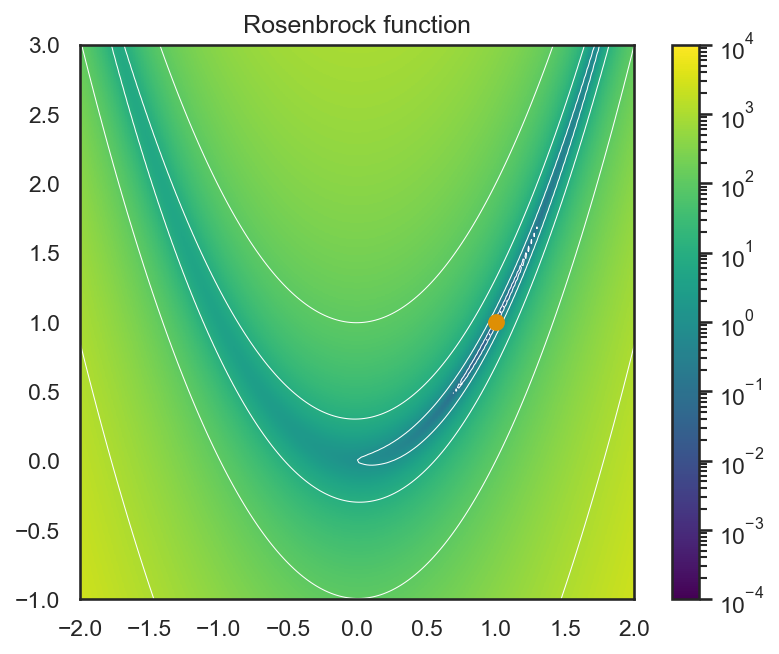

In [27]:
from matplotlib.colors import LogNorm

xs = np.linspace(-2.0, 2.0, 200)
ys = np.linspace(-1.0, 3.0, 200)
xs, ys = np.meshgrid(xs, ys)
extent = (-2.0, 2.0, -1.0, 3.0)
rosen = (1.0 - xs) ** 2.0 + 100.0 * (ys - xs**2.0) ** 2.0

fig, ax = plt.subplots()
mappable = ax.imshow(
    np.flip(rosen, axis=0), cmap="viridis", extent=extent, norm=LogNorm(vmin=1e-4, vmax=1.0e4)
)
ax.set(title="Rosenbrock function")
ax.contour(xs, ys, rosen, colors=["white"], linewidths=[0.5], norm=LogNorm(vmin=1e-4, vmax=1.0e4))
ax.scatter([1.0], [1.0], s=50, marker="o", color=color_palette[1], zorder=100)
fig.colorbar(mappable, ax=ax)
plt.show()

この関数は、$(1.0, 1.0)$の点を打った場所が関数の最小値をとる箇所になっているのだが、最小値の近傍が非常に狭い谷のような形になっており、さらにその谷が放物線上に湾曲しているため、この赤点の位置の最小値を求めることが困難であるとされている。

まずは$(x, y) = (0, 0)$として、Rosenbrock関数自体の値を計算してみる。

In [28]:
x = torch.tensor([0.0, 0.0], requires_grad=True)
f = (x[0] - 1.0) ** 2.0 + 100.0 * (x[1] - x[0] ** 2.0) ** 2.0
print(f"f(0, 0) = {f.item():f}")

f(0, 0) = 1.000000


次に、単一の変数の場合と同様に、出力の`f`に対して`backward`を呼び出して、$x, y$ (上記のコードでは`x`の0番目と1番目の要素に対応)に関する微分を求める。

In [29]:
f.backward()
print(f"df/dx at (0, 0) = {x.grad.tolist()}")

df/dx at (0, 0) = [-2.0, 0.0]


Rosenbrock関数の$x$, $y$に関する偏微分は、それぞれ

$$
\begin{align}
\frac{\partial f}{\partial x} &= 2a (x -1) - 4bx(y - x^2) \\
\frac{\partial f}{\partial y} &= 2b (y - x^2)
\end{align}
$$

であるので、$a = 1, b= 100$かつ$(x, y) = (0, 0)$であるとき、導関数の値は$(-2, 0)$になっており、上記の自動微分による結果と一致する。

続いては、Rosenbrock関数の二階導関数としてのHesse行列 (Hessianとも言う)を求めてみる。この場合は、先ほどの1変数の場合よりは多少工夫が必要になる。
まずは、`f`に対して`torch.autograd.grad`を計算する。

In [30]:
x = torch.tensor([0.0, 0.0], requires_grad=True)
f = (x[0] - 1.0) ** 2.0 + 100.0 * (x[1] - x[0] ** 2.0) ** 2.0
grad = torch.autograd.grad(f, inputs=x, create_graph=True)

安直には、この`grad`に対して、もう一度`torch.autograd.grad`関数を適用すれば良さそうだが、前述の通り`backward`関数や`torch.autograd.grad`関数は、出力がスカラー出ない場合には使うことができない。

In [31]:
try:
    H = torch.autograd.grad(grad, inputs=x)
except Exception as e:
    print("Exception:", e)

Exception: grad can be implicitly created only for scalar outputs


従って、ここで計算に一工夫が必要になる。ここで連鎖律の計算を思い出してほしい。連鎖律を計算するとき、スカラー値スカラー関数の場合には、$\text{d}z / \text{d}z = 1$から、連鎖律が始まり、その前の計算の微分を順に乗していくことで最終的な入力変数に関する微分を計算していたのであった。

この理屈で言えば、出力が二次元ベクトルであるような関数において、連鎖律のスタートとなるべき値は

$$
\begin{align}
\left( \frac{\partial x}{\partial x}, \frac{\partial y}{\partial x} \right) = (1, 0)
\left( \frac{\partial x}{\partial y}, \frac{\partial y}{\partial y} \right) = (0, 1)
\end{align}
$$

の2つとなることに気づく。そこで、このそれぞれを連鎖律のスタートとして`grad_outputs`パラメータに指定して`torch.autograd.grad`を呼び出してみる。

In [32]:
ddf_dxx = torch.autograd.grad(
    grad, inputs=x, grad_outputs=torch.tensor([1.0, 0.0]), retain_graph=True
)[0]
ddf_dyy = torch.autograd.grad(
    grad, inputs=x, grad_outputs=torch.tensor([0.0, 1.0]), retain_graph=True
)[0]
H = torch.stack([ddf_dxx, ddf_dyy], axis=0)

In [33]:
print(H)

tensor([[  2.,   0.],
        [  0., 200.]])


Rosenbrock関数のHesse行列は、解析的には

$$
\mathbf{H} = \begin{bmatrix}
2a + 4b (y - x^2) + 8bx^2 & -4bx \\
-4bx & 2b
\end{bmatrix}
$$

であるので、$a = 1, b = 100$, $(x, y) = (0, 0)$の時には、

$$
\mathbf{H} = \begin{bmatrix}
2 & 0 \\ 0 & 200
\end{bmatrix}
$$

となり、自動微分の結果が解析的な微分結果と一致していることが分かる。

## ニュートン法の実装

それでは、ここで練習としてニュートン法を用いてRosenbrock関数の最小値を求めてみよう。ニュートン法は、Hesse行列$\mathbf{H}$と、$f$の勾配$\nabla f$を用いて、

$$
\boldsymbol\delta = \mathbf{H}^{-1} \nabla f
$$ (eq:newton-step)

のように更新幅を計算するような、繰り返し最適化法の一種である。これは、関数$f(\mathbf{x})$の$\boldsymbol\delta$周りのTaylor展開により、

$$
f(\mathbf{x} + \boldsymbol\delta) \approx f(\mathbf{x}) + \frac{1}{1!} \boldsymbol\delta^\top \nabla f(\mathbf{x}) + \frac{1}{2!} \boldsymbol\delta^\top \mathbf{H} \boldsymbol\delta
$$

となることから説明できる。この式を変形すると、

$$
\frac{\text{d} f}{\text{d} \boldsymbol\delta}(\mathbf{x}) = \nabla f(\mathbf{x}) + \frac{1}{2} \mathbf{H}\boldsymbol\delta
$$

という式が得られる。従って、Taylor展開の第2項までで元の関数を近似した範囲においては、$\text{d} f / \text{d}\boldsymbol\delta = \mathbf{0}$となるような場所に移動することで、関数の最小値に近づくことができる (これは、関数を局所的に二次関数で近似して、その二次関数の「底」に移動することに対応する)。

実際には、最小化すべき関数が局所的に二次関数で近似できることばかりではないので、通常は{eq}`eq:newton-step`で求まった更新方向に小さな定数$\alpha$を乗じて$\mathbf{x}$の値を

$$
\mathbf{x}^{t+1} = \mathbf{x}^t + \alpha \boldsymbol\delta
$$

のように更新することが多い。

では、ここまでの議論を踏まえて、実際に自動微分により求めたHesse行列を用いてRosenbrock関数を最小化してみよう (以下にコードと実行結果を示すが、まずは自分自身で考えてみてほしい)。

In [34]:
def rosenbrock(x):
    """Rosenbrock function"""
    return (x[0] - 1.0) ** 2.0 + 100.0 * (x[1] - x[0] ** 2.0) ** 2.0

In [35]:
initial_x = np.array([-1.0, 1.5])


def calc_newton_step(f, x):
    grad = torch.autograd.grad(f, inputs=x, create_graph=True)[0]
    gx = torch.autograd.grad(
        grad,
        inputs=x,
        grad_outputs=torch.tensor([1.0, 0.0]),
        retain_graph=True,
    )[0]
    gy = torch.autograd.grad(
        grad,
        inputs=x,
        grad_outputs=torch.tensor([0.0, 1.0]),
        retain_graph=True,
    )[0]
    H = torch.stack([gx, gy], axis=0)

    return torch.linalg.solve(H, grad)


x = torch.tensor(initial_x, requires_grad=True)
pts = []
for i in range(100):
    pts.append(x.detach().numpy())
    fx = rosenbrock(x)
    dx = calc_newton_step(fx, x)
    x = x - 0.5 * dx
    x = x.detach().requires_grad_(True)

print("The answer is:", x.detach().numpy())

The answer is: [1. 1.]


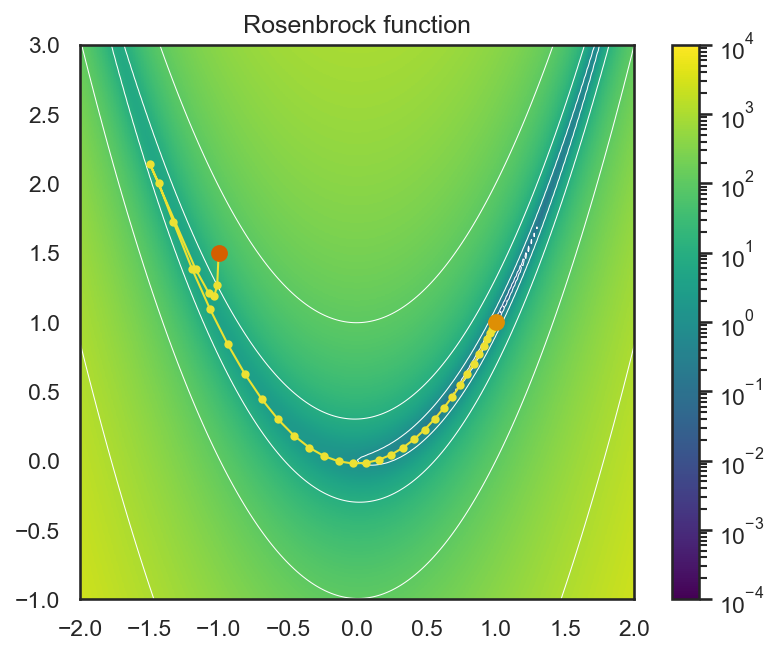

In [36]:
from matplotlib.colors import LogNorm

xs = np.linspace(-2.0, 2.0, 200)
ys = np.linspace(-1.0, 3.0, 200)
xs, ys = np.meshgrid(xs, ys)
extent = (-2.0, 2.0, -1.0, 3.0)
rosen = (1.0 - xs) ** 2.0 + 100.0 * (ys - xs**2.0) ** 2.0

fig, ax = plt.subplots()
mappable = ax.imshow(
    np.flip(rosen, axis=0), cmap="viridis", extent=extent, norm=LogNorm(vmin=1e-4, vmax=1.0e4)
)
ax.set(title="Rosenbrock function")
ax.contour(xs, ys, rosen, colors=["white"], linewidths=[0.5], norm=LogNorm(vmin=1e-4, vmax=1.0e4))
ax.scatter([1.0], [1.0], s=50, marker="o", color=color_palette[1], zorder=100)
ax.scatter(initial_x[0], initial_x[1], s=50, marker="o", color=color_palette[3], zorder=100)

# 軌跡のプロット
pts = np.array(pts)
ax.plot(pts[:, 0], pts[:, 1], color=color_palette[8], marker="o", markersize="3.0", linewidth=1.0)

fig.colorbar(mappable, ax=ax)
plt.show()

この図では、$(0.0, 0.0)$の初期値から$(1.0, 1.0)$の最小値に至るまでの最適化の過程をマーカー付きの曲線で示している。各マーカーの位置を見てみると、徐々に最小値に至るスピードが遅くなりつつも、正しく関数の最小値を取る箇所に収束していることが分かる。

Rosenbrock関数の最小化については、解の初期値やニュートン法のステップ幅を変化させることで、収束が不安定になって最小解からはずれて・近づいてを繰り返すような軌跡を描くこともある。ぜひ、いろいろなパラメータで軌跡を描画して、その性質の理解に努めて欲しい。

:::{admonition} 機械学習と損失関数
:class: note

ここでは、関数の勾配を求めて、勾配法により関数を最小化する問題を解いた。深層学習は、ニューラルネットのパラメータを変数として、その変数を同じく勾配法により最適化する問題であり、最小化する関数は**損失関数**(loss function)と呼ばれる (反対に目的を達成するために最大化される関数を**目的関数**と呼ぶ)。

ニューラルネットのパラメータ最適化(=訓練)には、ニュートン法や準ニュートン法のような損失関数の二階微分を考慮するような方法を用いることは少なく (ただしAdaSecant{cite}`gulcehre2014adasecant`のような二階微分を考慮する方法もある)、多くの場合は単純な確率的最急降下法やRMSprop, Adamのようなアルゴリズムが使われることが多い。これは、パラメータ数が多くなると、Hesse行列を求めるのに多くの計算量が必要になるためで、そうであれば、一階微分だけが求まれば実行できる最急降下法を安定化させるように工夫する方が良い、という発想である。
:::

::::{admonition} 問
:class: question

上記のニュートン法により得られた関数最小化の軌跡を、単純な[最急降下法](https://en.wikipedia.org/wiki/Gradient_descent)ならびに一階導関数だけを用いてHesse行列を近似する[準ニュートン法](https://en.wikipedia.org/wiki/Quasi-Newton_method)と比較せよ。

::::

### オプティマイザを利用した最適化

PyTorchには**オプティマイザ**というモジュールが用意されており、一階微分量を用いる最急降下法を対象として、さまざまなアルゴリズムが提供されている。ニューラルネットワークの訓練においては、確率的に選ばれたミニバッチから、パラメータを更新する勾配を求めるので、モジュールの名前としては確率的最急降下法 (SGD = stochastic gradient descent)を基本としたものとなっている。

#### 確率的最急降下法

最も単純な**確率的最急降下法**では、誤差関数を$\mathcal{L}$、パラメータを$\theta$、更新のステップ幅 (=更新率)を$\gamma$として、パラメータ$\theta$を以下の式で更新する。

$$
\theta_{t+1} = \theta_{t} - \gamma \frac{\partial\mathcal{L}}{\partial \theta_{t}}
$$

しかし、単純な確率的最急降下法はパラメータの更新方向が安定しないという問題があり、**モメンタム**(慣性)を使って、急激に勾配方向が変わらないように移動平均を取るアルゴリズム (**Momentum SGD**)もある。Momentum SGDの更新式は以下の通り ([参照](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html))。

$$
\begin{align}
\theta_{t+1} &= \theta_{t} - \gamma g_{t+1} \\
g_{t+1} &= \mu g_{t} + \frac{\partial\mathcal{L}}{\partial \theta_{t}}
\end{align}
$$

このように、慣性パラメータとして$\mu$ ($0 < \mu < 1$)を導入することで、過去の更新方向を一定の割合で残しつつ、パラメータの更新を行う。

#### RMSprop

最急降下法のもう一つの問題に**解の振動**が挙げられる。これはパラメータ更新のステップ幅が大きすぎるために、谷のような形状の両岸を行ったり来たりしてしまうような現象である。当然、ステップサイズを小さくすればその影響は抑えられるが、その分、最適化の収束は遅くなってしまう。

このような振動の問題を防ぐアルゴリズムの一つに**RMSprop** (root-mean-square propagation)がある。RMSpropは、その名前にある通り、勾配の二乗平均平方根を取り、その値が履歴として大きいパラメータの更新を抑制する。振動が起こっている時は、本来更新しなくても良い方向に行ったり来たりしてしまっているわけだから、このような過去の更新量に基づく調整が有効に働くことが分かるだろう。

RMSpropのパラメータ更新式は以下の通り ([参考](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html))。

$$
\begin{align}
\theta_{t+1} &= \theta_t + \gamma \frac{g_{t+1}}{\sqrt{v_{t+1} + \epsilon}} \\
v_{t+1} &= \alpha v_{t} + (1 - \alpha) g_{t+1}^2 \\
g_{t+1} &= \frac{\partial\mathcal{L}}{\partial\theta_{t}}
\end{align}
$$

この式が示すとおり$v_{t}$は、過去の勾配の二乗を時間平均したもので、その平方根の逆数を勾配$g_t$に乗ずることで、過去に多く更新されているパラメータの更新を抑制している。なお、$\epsilon$はゼロ除算を防ぐための定数でPyTorchでは初期値として$1 \times 10^{-8}$が設定されている。

#### Adam

**Adam** (adaptive momentum method)は、前述のMomentum SGDとRMSpropを組み合わせたアルゴリズムで、確率的最急降下法の勾配方向の不安定性と振動の問題を両方解決するように設計されている。

Adamには更新率$\gamma$と合わせて、二つのパラメータ$\beta_1$と$\beta_2$を設定する。これらのうち$\beta_1$は、勾配方向に慣性を調整するパラメータで1に近い値を取るほど、強く慣性が働き、過去の勾配の影響を強く残す。一方、$\beta_2$は、振動の抑制に働くパラメータで、1に近い値が取るほど、過去の勾配の大きさを考慮して更新量を抑制するようになる。

また、これに加えて、$\beta_1$, $\beta_2$を用いて、最適化の始めは大きなステップサイズで更新を行い、徐々にその効果を弱めていくという計算もなされている。

#### オプティマイザを使用した最適化

深層学習では、上記のSGDやAdam等のオプティマイザを用いてニューラルネットワークのパラメータを最適化するのだが、この仕組みは最急降下法等の一階微分を用いる最適化問題にも使用することができる。

そこで、深層学習に進む前に、まずは前述のRosenbrock関数を上記のオプティマイザを使って最適化し、その違いについて見てみよう。

データローダとは、PyTorchを用いたニューラルネットワークの学習において、ミニバッチ学習を簡単にするための仕組みである。通常、深層学習には大量の訓練データが必要であり、それら全てを考慮したパラメータの更新方向(=勾配)を求めることは現実的ではない。

そこで、大量の訓練データから少数のデータ、すなわちミニバッチをサンプルし、そのミニバッチ内のデータによって与えられる勾配が、データ全体から求まる勾配の近似として十分に正しく動作することを仮定する。データから収集してくるミニバッチの数は`torch.utils.data.Dataset`型のサブクラスとして用意されたデータセット・クラスを引数にとる`torch.data.utils.data.DataLoader`によって制御できる。

では、上記のひらがな73文字データセットについて、まずはデータの読み出しを行う役割を持つデータセット・クラスを作成してみよう。データセット・クラスは`torch.utils.data.Dataset`型のサブクラスとして実装する。この際、コンストラクタと合わせて、データの総数を返す`__len__`関数と、データ1つをサンプルする`__getitem__`関数の二つを実装する。

In [37]:
# 比較するオプティマイザのリスト
optims = {
    "SGD": lambda x: torch.optim.SGD([x], lr=2.0e-3),
    "Momentum-SGD": lambda x: torch.optim.SGD([x], lr=2.0e-3, momentum=0.9),
    "RMSprop": lambda x: torch.optim.RMSprop([x], lr=2.0e-3),
    "Adam": lambda x: torch.optim.Adam([x], lr=2.0e-3),
}

# 各オプティマイザの軌跡を保存する
plots = {}
for name, opt in optims.items():
    x = torch.tensor(initial_x, requires_grad=True)
    optim = opt(x)

    history = []
    for i in range(10000):
        # 現在の点を保存
        history.append(x.clone().detach().numpy())

        # パラメータの更新
        y = rosenbrock(x)
        optim.zero_grad()
        y.backward()
        optim.step()

    plots[name] = np.array(history)

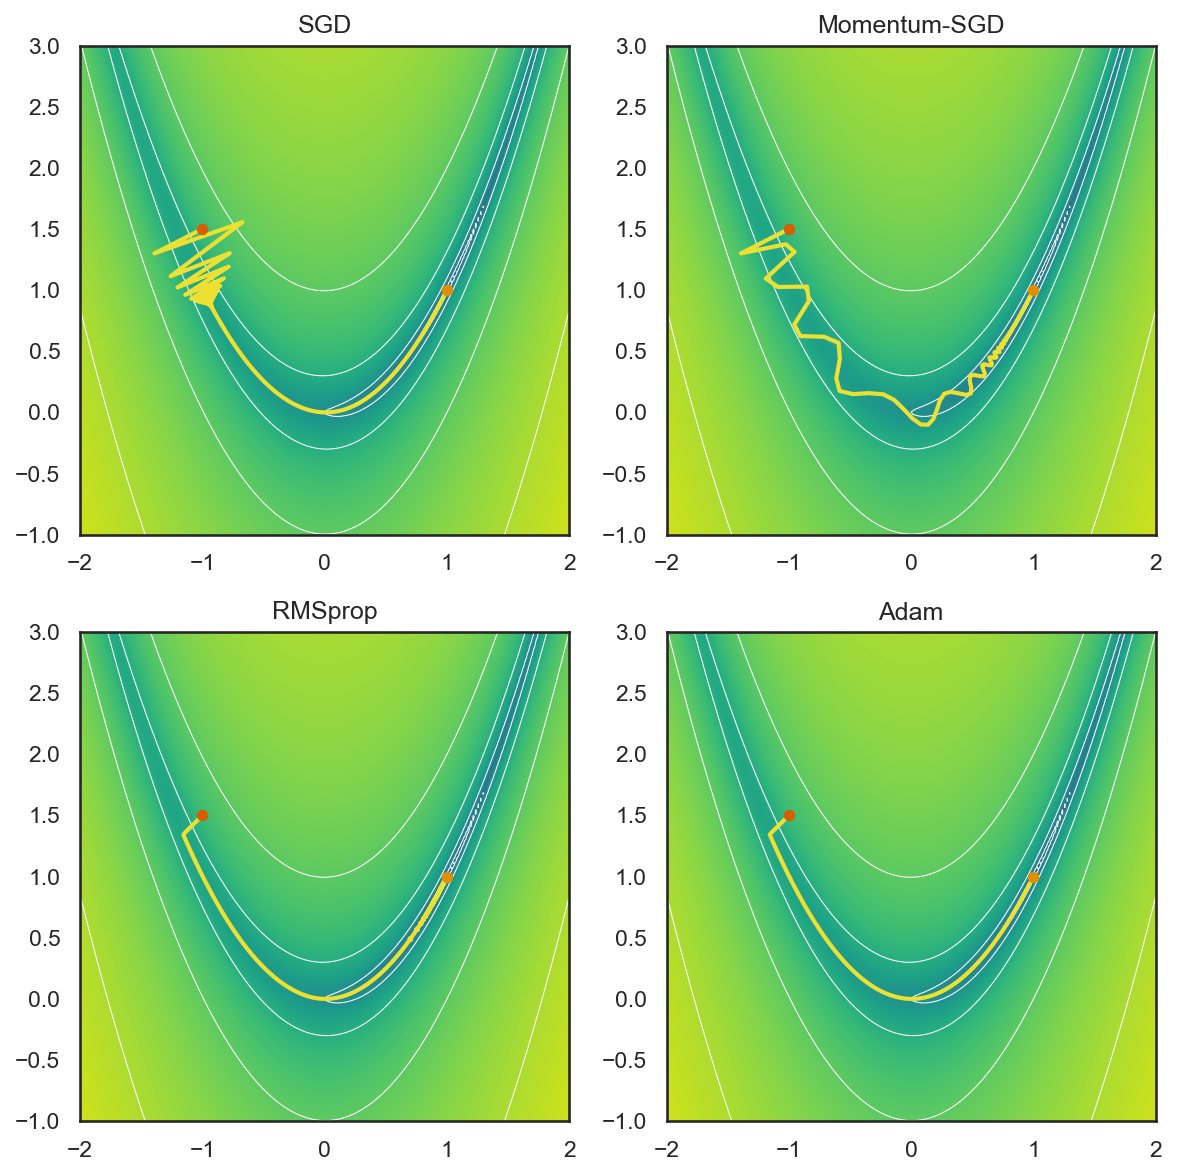

In [38]:
xs = np.linspace(-2.0, 2.0, 200)
ys = np.linspace(-1.0, 3.0, 200)
xs, ys = np.meshgrid(xs, ys)
extent = (-2.0, 2.0, -1.0, 3.0)
rosen = (1.0 - xs) ** 2.0 + 100.0 * (ys - xs**2.0) ** 2.0

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2, figure=fig)

for i, (name, pts) in enumerate(plots.items()):
    ax = plt.subplot(gs[i])
    mappable = ax.imshow(
        np.flip(rosen, axis=0),
        cmap="viridis",
        extent=extent,
        norm=LogNorm(vmin=1e-4, vmax=1.0e4),
    )
    ax.set(title=name, xlim=[-2.0, 2.0], ylim=[-1.0, 3.0])
    ax.contour(
        xs, ys, rosen, colors=["white"], linewidths=[0.5], norm=LogNorm(vmin=1e-4, vmax=1.0e4)
    )
    ax.scatter(initial_x[0], initial_x[1], s=20, marker="o", color=color_palette[3], zorder=100)
    ax.scatter([1.0], [1.0], s=20, marker="o", color=color_palette[1], zorder=100)

    ax.plot(
        pts[:, 0],
        pts[:, 1],
        # marker="o",
        markersize="2.0",
        color=color_palette[8],
        linewidth=2.0,
        label=name,
    )

plt.tight_layout()
plt.show()

上記の結果を見てみると、SGDは最初の方で、解が大きく振動しているのに対して、Momentum SGDでは、それが多少緩和されていることが分かる。また、更新量から、その勾配を調整する仕組みが入っているRMSpropやAdamでは、ほとんど解が振動することなく、Rosenbrock関数の谷に沿って、解が収束している。

このような、最適化手法の性質の違いに留意しつつ、適切なオプティマイザを選ぶことが好ましい。ただし、オプティマイザに関しては、Adamの発展形などもいろいろと提案されており、新しいものを使おうとすると切りがないため、深層学習を使って研究する場合には、現在、他の多くの研究で用いられているものを使っておくのが無難だろう。

## 深層学習

PyTorchを使った深層学習をするために準備すべきことはいくつかある。以下では、

- [データローダの準備](ssec:dataloader-preparation)
- [ネットワークの構築](ssec:network-architecture)
- [オプティマイザの準備](ssec:optimizer-preparation)
- [損失関数の設定](ssec:loss-function)
- [学習ループの実装](ssec:training-loop)

のそれぞれについて順に説明する。

(ssec:dataloader-preparation)=
### データローダの作成

データローダとは、PyTorchを用いたニューラルネットワークの学習において、ミニバッチ学習を簡単にするための仕組みである。通常、深層学習には大量の訓練データが必要であり、それら全てを考慮したパラメータの更新方向(=勾配)を求めることは現実的ではない。

そこで、大量の訓練データから少数のデータ、すなわちミニバッチをサンプルし、そのミニバッチ内のデータによって与えられる勾配が、データ全体から求まる勾配の近似として十分に正しく動作することを仮定する。データから収集してくるミニバッチの数は`torch.utils.data.Dataset`型のサブクラスとして用意されたデータセット・クラスを引数にとる`torch.data.utils.data.DataLoader`によって制御できる。

では、上記のひらがな73文字データセットについて、まずはデータの読み出しを行う役割を持つデータセット・クラスを作成してみよう。データセット・クラスは`torch.utils.data.Dataset`型のサブクラスとして実装する。この際、コンストラクタと合わせて、データの総数を返す`__len__`関数と、データ1つをサンプルする`__getitem__`関数の二つを実装する。

In [39]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class HiraganaDataset(Dataset):
    """
    ひらがな46文字データセット
    """

    CHARS = "あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゆよらりるれろわをん"
    N_IMAGES_PER_CHAR = 200

    def __init__(self, dataroot, transform=None):
        super(HiraganaDataset, self).__init__()

        self.dataroot = dataroot
        self.transform = transform
        self.n_classes = len(self.CHARS)

        # 各ひらがなの画像が入っているフォルダを列挙
        char2num = {c: i for i, c in enumerate(self.CHARS)}
        folders = [f"U{ord(c):04X}" for c in self.CHARS]
        folders = [os.path.join(self.dataroot, d) for d in folders]

        # 各フォルダに含まれる画像ファイルを列挙、配列に格納
        self.data = []
        for d in folders:
            char = os.path.basename(d).replace("U", "0x")
            char = chr(int(char, 16))
            num = char2num[char]

            image_files = [os.path.join(d, f) for f in os.listdir(d)]
            image_files = [f for f in image_files if f.endswith(".png")]
            if len(image_files) > self.N_IMAGES_PER_CHAR:
                image_files = np.random.choice(image_files, self.N_IMAGES_PER_CHAR, replace=False)

            image_files = sorted(image_files)
            self.data.extend([(f, num) for f in image_files])

    def __len__(self):
        """ファイルの総数を返す"""
        return len(self.data)

    def __getitem__(self, idx):
        """データ1つをサンプルする"""
        image_file, num = self.data[idx]
        image = Image.open(image_file)
        if image is None:
            raise IOError("Failed to load image: {:s}".format(f))

        if self.transform is not None:
            image = transform(image)

        return image, num

さて、上記のデータセット・クラスにはコンストラクタの引数に`transform`という変数が渡されている。PyTorchではTorchVisionの`transforms`モジュールに用意されたデータ操作のためのクラスを用いることで、簡単にデータの前処理を行うことができる。

なお、PyTorch 2.0以降は`transforms.v2`という新しいモジュールが導入されており、従来の`transforms`よりも幅広いタスクを前処理に追加することができる ([参考](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html))。本項でも`v2`を使用して前処理を行なっていく。

`transforms`を用いると、例えば、[特徴量の抽出](sec:feature-extraction)で行っていたような

- 画像をグレースケールに変更
- 画像をランダムに回転、拡大・縮小

といった操作は `v2.GrayScale`や`v2.RandomAffine`によって実現することができる。複数の前処理操作を組み合わせる場合には、`v2.Compose`に前処理を行うクラス・インスタンスの配列を渡せば良い。

PyTorchの学習には、`torch.Tensor`型かつ`float32`型の変数を用いるので、上記の二つの前処理と合わせて、型の変換を行う`v2.ToImage` (`torch.Tensor`型への変更)と`v2.ToDtype` (データ内部の数値型を指定された型に変更する)を`v2.Compose`に与えている。

In [40]:
# TorchVision
from torchvision.transforms import v2

transform = v2.Compose(
    [
        v2.Grayscale(),  # 画像のグレースケール化
        v2.RandomAffine(degrees=[-60, 60], scale=[0.8, 1.1]),  # ランダム回転、拡大・縮小
        v2.ToImage(),  # torch.Tensorに型変換
        v2.ToDtype(torch.float32, scale=True),  # データ型を32bit浮動小数に変換
    ]
)

`transform`の準備ができたら、これを前処理計算として、データセット・クラスをインスタンス化する。

In [41]:
dataset = HiraganaDataset(dataroot="hiragana73", transform=transform)
n_classes = dataset.n_classes
print(f"{len(dataset):d} images from {n_classes:d} classes")

9200 images from 46 classes


このようにして作られたデータセットクラスはscikit-learnの時と同様に `torch.utils.data.random_split`関数を使うことで、訓練用とテスト用にデータを分割することができる。

In [42]:
train_data, test_data = torch.utils.data.random_split(dataset, lengths=[0.8, 0.2])
print(f"#train: {len(train_data):d}, #test: {len(test_data):d}")

#train: 7360, #test: 1840


データセットの分割が完了したら、最後に`torch.utils.data.DataLoader`のインスタンス化を行う。このクラスはデータに対するイテレータとして用いることができ、予め`batch_size=...`で指定した数のデータを含むミニバッチを順に取り出してくれる。この際、データの順序をランダムにシャッフルするかどうかは`shuffle=...`で制御できる。訓練データはシャッフルを行い、テストデータはシャッフルを行わないで用いることが多い。

In [43]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(ssec:network-architecture)=
### ネットワークの構築

学習可能なニューラルネットワークは`nn.Module`クラスを継承することで作成できる。まずは、単純な実装として、ひらがなの画像 (48×48画素)を2304次元ベクトルとして扱う場合について見てみる。

今回は、ひらがなの種類が73次元であるので、ネットワークが出力するべきものは73次元のベクトルで、それぞれの要素が、画像がどのひらがならしいかを表わす確率であるようなものである。

このようなベクトルからベクトルへの変換をいわゆる全結合層の連結によって表わすようなネットワークを特に**マルチレイヤ・パーセプトロン**(multilayer perceptron)やMLPと呼ぶ。

#### 全結合層

**全結合層** (fully-connected layer)は、入力のベクトル$\mathbf{x} \in \mathbb{R}^n$に対して、**重み行列** $\mathbf{W} \in \mathbb{R}^{m \times n}$と**バイアスベクトル** $\mathbf{b} \in \mathbb{R}^m$を使って

$$
\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}
$$ (eq:fully-connected)

のように$\mathbf{y} \in \mathbb{R}^m$に変換する操作を表わす。従って、全結合層における学習可能なパラメータは$\mathbf{W}$と$\mathbf{b}$ということになる。

この全結合層が行う操作は{eq}`eq:fully-connected`から分かるように**線形の演算**である。

現在の深層学習においては、以下に示す畳み込みニューラルネットで用いられる畳み込み層など、学習可能なパラメータを含む操作は多くの場合、線形の演算によって定義されることがほとんどである。

#### 活性化関数

しかし、線形の操作を入力のベクトルに対して何回繰り返したところで、それは所詮線形の操作に他ならない。通常の機械学習において扱う入出力の関係は線形なものばかりではないので、深層学習以前にはカーネル法などを用いて非線形な関係を学習するなどの工夫を取り入れていた。

深層学習においては、学習可能なパラメータを含む演算を線形演算で表わす代わりに非線形の**活性化関数**を用いて、ニューラルネットが表わす入出力データの関係に非線形性を持たせる。

現在の深層学習において、最も広く用いられている活性化関数は**ReLU** (rectified linear unit)と呼ばれるものである。この関数は入力の正の部分だけを残すような関数で、式としては

$$
f_\text{ReLU}(x) = \begin{cases}
    0 & (x < 0) \\
    x & (\text{otherwise})
\end{cases}
$$

のように書ける。

以前は、このような活性化関数として、ソフトな閾値関数であるシグモイド関数が使われていた。シグモイド関数$\sigma(x)$は

$$
\sigma(x) = \frac{1}{1 + \exp(-x)}
$$

のような関数であり、以下のようなグラフを取る。

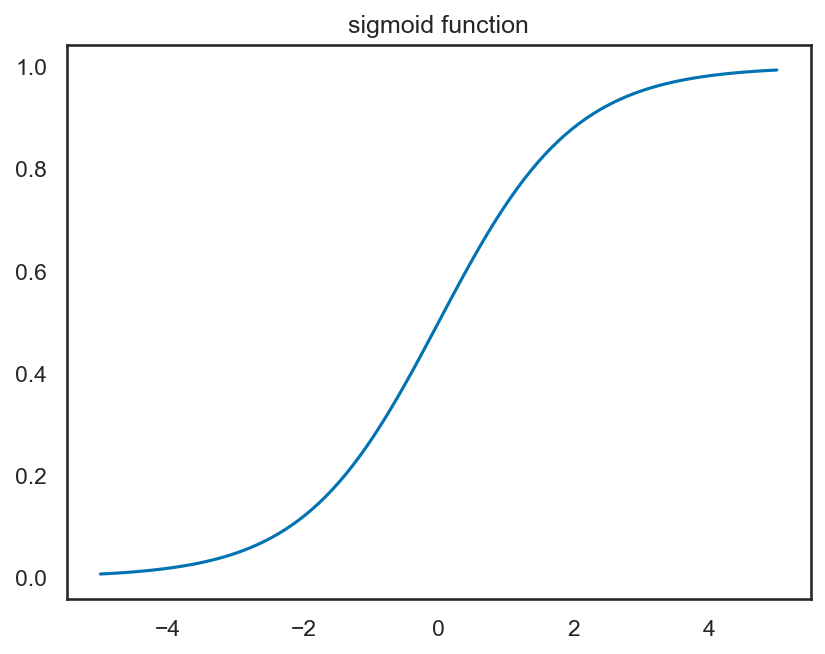

In [44]:
x = np.linspace(-5.0, 5.0, 100)
y = 1.0 / (1.0 + np.exp(-x))
plt.plot(x, y)
plt.title("sigmoid function")
plt.show()

このように、シグモイド関数は入力が0以上の時に1に近い値を、入力が0以下の時に0に近い値を返すようなものであり、これが人間のニューロン同士の結びつきをうまく表わしていると考えられていた。

しかし、実際にニューラルネットの学習を数値計算によって実現しようとする場合、シグモイド関数による活性化は**勾配消失**の問題を引き起こすことが分かった。

勾配消失とは、連鎖律によって、入力の値に関する出力の勾配を求めていく過程で、小さな値が何度もかけ算され、数値誤差により勾配が0になってしまう現象である。シグモイド関数の微分は、

$$
\sigma'(x) = \frac{e^{-x}}{(1 + e^{-x})^2}
$$

なのだが、これは、元のシグモイド関数を用いて、

$$
\sigma'(x) = \sigma(x) (1 - \sigma(x))
$$

のように書き直せる。シグモイド関数の性質から$x$が正負どちらかの方向に大きな値をとれば、1あるいは0に近づいていくため、シグモイド関数の微分$\sigma'(x)$は、入力の$x$が0から外れた値を取ると、急激に小さくなることが分かる。

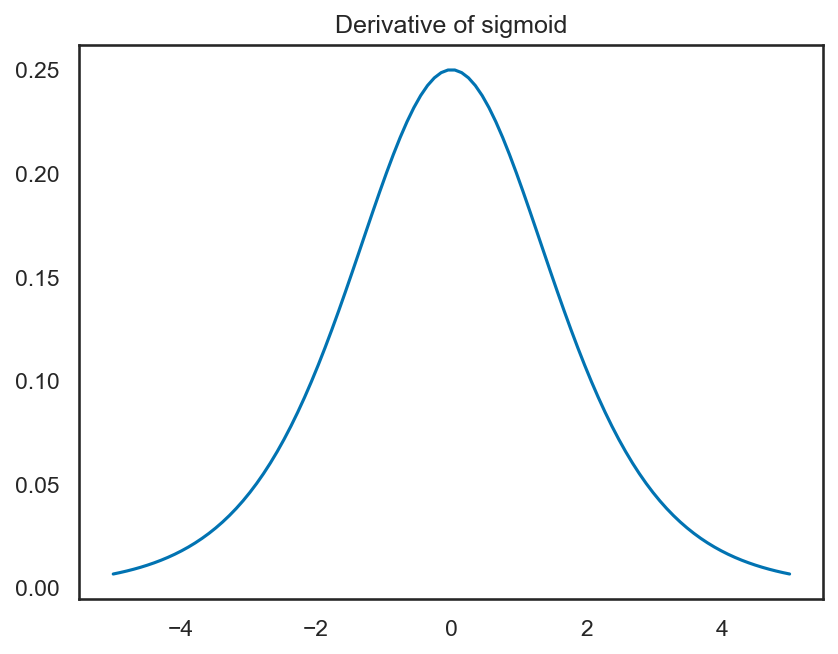

In [45]:
x = np.linspace(-5.0, 5.0, 100)
sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))
y = sigmoid(x) * (1.0 - sigmoid(x))
plt.plot(x, y)
plt.title("Derivative of sigmoid")
plt.show()

この勾配消失により、ニューラルネットの入力に近い側の層において学習が上手く進まないことが長く問題とされてきたが、ReLUは、その導関数が0か1なので、シグモイド関数で問題となっていたような勾配消失の問題が起きづらくなっている。

このような理由から、現在の深層学習においてはReLUおよび、その変形を活性化関数として用いることが多いのである。

#### データ正規化

現在の深層学習においては、バッチ正規化 (batch normalization)を始めとしたデータ正規化をネットワーク上に配置することが多い。これは、スケールの異なるデータに対して、ニューラルネットがパラメータを統一的に学習するのに役立つ。

例えば、バッチ正規化の場合、ミニバッチに含まれるデータに対して計算されている特徴の平均と分散をミニバッチ内で計算し、データの平均が0、標準偏差が1となるように正規化を行う。

この効果はバイアスベクトルを例に取ると分かりやすい。もしデータ正規化を行わない場合、ニューラルネットは輝度がとある画像と輝度が一様に持ち上がった画像を区別するために、異なるバイアスベクトルを学習しなければならない。

しかし、データ正規化によってデータの平均値が0になるように正規化されていれば、一様に輝度が持ち上がるなどの変化を学習パラメータの違いによって判別する必要がなくなるため、よりニューラルネットの学習が効率的に進むようになる。

ただし、このようなデータ正規化は正規化を行うデータ群 (バッチ正規化であればミニバッチ)が、元のデータセットに含まれるデータの分布を上手く近似できていることを仮定しているので、ミニバッチのサイズが小さく、データ分布の近似的精度が悪い場合には、学習が逆に上手く進まないこともあるので注意すること。

なお、PyTorchを始めとする深層学習用のライブラリにおいて、データ正規化のモジュール(`nn.BatchNorm1d`や`nn.InstanceNorm1d`など)は単なるバッチ内でのデータの正規化に加えて、さらに平均と標準偏差を調整するようなパラメータを学習可能変数として持っている。

#### 単純なマルチレイヤ・パーセプトロン

では、ここまでの議論を踏まえて、単純なマルチレイヤ・パーセプトロンを実装してみる。PyTorchにおいては、**学習可能パラメータを含むモジュールはコンストラクタで定義しておく必要がある**ため、以下のコードでは、全結合層を表わす`nn.Linear`と、バッチ正規化を表わす`nn.BatchNorm1d`をコンストラクタの中でインスタンス化しておく。

今回、活性化関数として用いるReLUは学習可能パラメータを持たないので、こちらは、特にコンストラクタでは用意せずに、実際のネットワークが表わす関数の評価処理に対応する`forward`関数の中で`torch.relu`を呼び出す。

理由については後述するが、最終の全結合層に対する活性化関数には単なるソフトマックス関数ではなく、対数ソフトマックス関数を取る方が良い。

In [46]:
class Network(nn.Module):
    """
    シンプルなマルチレイヤ・パーセプトロン
    """

    def __init__(self, in_features, out_features):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(in_features, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, out_features)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = torch.relu(x)
        x = self.bn2(self.fc2(x))
        x = torch.relu(x)
        x = self.fc3(x)
        y = F.log_softmax(x, dim=1)
        return y

また、PyTorchには`nn.Module`のサブクラスである`nn.Sequential`があり、ニューラルネットを構成するモジュールを引数として与えることで、それを順に実行させることもできる。すると、上記の実装はもう少しすっきりと以下のように書ける。

In [47]:
class Network(nn.Sequential):
    """
    nn.Sequentialを継承した例
    """

    def __init__(self, in_features, out_features):
        super(Network, self).__init__(
            nn.Linear(in_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, out_features),
            nn.LogSoftmax(dim=1),
        )

このようにして実装したニューラルネットは入出力の次元数を与えて、以下のようにインスタンス化しておく。

In [48]:
model = Network(48 * 48, n_classes)

このようにしてモデルを作成したら訓練時には`model.train()`を、評価時には`model.eval()`を予め呼び出しておく (後述のソースコードを参照)。

`train()`や`eval()`を呼び出すと、バッチ正規化や後述するドロップアウトの挙動が変化するため、必ずしも訓練時と同じデータでも同じ精度が出ない可能性があることに留意したい。

(ssec:optimizer-preparation)=
### オプティマイザの準備

やや天下り式ではあるが、今回は、多くの問題に対して、それなりに良い性能を発揮するAdamをオプティマイザに用いる。ニューラルネットの学習可能パラメータは`parameters`関数で得られるので、これをオプティマイザの第一引数に指定する。

In [49]:
optim = torch.optim.Adam(model.parameters(), lr=1.0e-4)

(ssec:loss-function)=
### 損失関数の設定

**損失関数** (loss function)は、ニューラルネットを訓練するための基準を決める関数であり、問題の種類ごとに、おおよそどのような関数を使えば良いかが決まっている。

識別問題の場合には、2クラス分類なら二値交差エントロピー (binary cross entropy)を、多クラス分類なら交差エントロピー(cross entropy)を用いるのが一般的である。これらを$\mathcal{L}_{\rm BCE}$, $\mathcal{L}_{\rm CE}$と書くことにすると、それぞれ以下の式で表わされる。

$$
\begin{align}
\mathcal{L}_{\rm BCE} &= - y \log x - (1 - y) \log (1- x) \\
\mathcal{L}_{\rm CE} &= - y \log x
\end{align}
$$

なお、$y \in \lbrace 0, 1\rbrace$, $x \in [0, 1]$はそれぞれ正解のラベルと、予測のラベルを表わす。

交差エントロピーには、回帰問題で一般的に用いられる最小二乗誤差などと比べて、ラベルが正解から外れている時に、大きなペナルティが与えられる、という特徴があるため、より分類問題に向いた誤差指標と言える。

#### Softmax関数の計算

さて、ここで一つ重要な問題がある。多クラス分類の場合、予測ラベルは、その値が0から1の範囲に収まるようにソフトマックス関数によって活性化されることが一般的である。活性化前の特徴ベクトルを$\mathbf{x}$とすると、活性化後のラベル$\mathbf{y}$の各次元$y_d$は、以下の式で与えられる。

$$
y_d = \frac{e^{x_d}}{\sum_{d} e^{x_d}}
$$

この式を見て分かる通り、ソフトマックス関数は分母と分子に指数関数を含むため、$\mathbf{x}$のようそが少し大きな値を取るだけで、ニューラルネットワークの学習に一般的に用いられる単精度浮動小数で表せる範囲を超えてしまう。

そのため、実際のソフトマックス関数の計算においては、予め分母と分子を$\mathbf{x}$のうち最大の要素を$\max_j x_j$として、$e^{\max_j x_j}$で割り算をしておく、ということをする。

より具体的には、以下の式によりソフトマックス関数を計算する。

$$
y_d = \frac{e^{x_d - \max_j x_j}}{\sum_{d} e^{x_d - \max_j x_j}}
$$

この違いを実際に計算して確かめてみよう。

In [50]:
# 0-100の間の乱数
np.random.seed(3)
x = torch.tensor(np.random.uniform(0, 100, size=(10)), dtype=torch.float32)

# 単純な計算
softmax0 = torch.exp(x) / torch.exp(x).sum()

# 工夫した計算
max_x = torch.max(x)
softmax1 = torch.exp(x - max_x) / torch.exp(x - max_x).sum()

# 結果の表示
print(" Input:", x)
print("Simple:", softmax0)
print("Better:", softmax1)

 Input: tensor([55.0798, 70.8148, 29.0905, 51.0828, 89.2947, 89.6293, 12.5585, 20.7243,
         5.1467, 44.0810])
Simple: tensor([0., 0., 0., 0., nan, nan, 0., 0., 0., 0.])
Better: tensor([5.7665e-16, 3.9313e-09, 2.9778e-27, 1.0593e-17, 4.1712e-01, 5.8288e-01,
        1.9686e-34, 6.9264e-31, 1.1892e-37, 9.6426e-21])


いかがだろうか。このように、単純にソフトマックス関数を計算してしまうと、入力の$\mathbf{x}$に一つ、大きな値が含まれるだけで、計算に失敗してしまうことが分かる。自分でソフトマックス関数を書く場合には注意されたい (特にNumPyには標準のソフトマックス関数が実装されていない)。

#### SoftmaxとLogSoftmax

さて、続いてはソフトマックス関数(softmax)と、対数ソフトマックス関数(log-softmax)の違いについて見ていきたい。前述のニューラルネットワークでは、最終層の活性化関数に対してソフトマックス関数ではなく対数ソフトマックス関数を用いていたが、もちろんこれにも意味がある。

例えば、次の例を見てみてほしい。

In [51]:
np.random.seed(3)
x = torch.tensor(np.random.uniform(-100, 100, size=(10)), dtype=torch.float32)
softmax = F.softmax(x, dim=0)
print("Softmax:", softmax)

Softmax: tensor([6.4727e-31, 3.0083e-17, 0.0000e+00, 2.1843e-34, 3.3867e-01, 6.6133e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8099e-40])


この例では、ソフトマックス関数の出力で、単精度浮動小数では表せないような微小な値が出てきてしまい、アンダーフローが起こって、一部の値が0になっていることが分かる。このような出力に対して対数を取ってしまえば、$-\infty$のような好ましくない値が得られてしまう。

これは、交差エントロピー誤差の計算に影響を与える。前述の通り、交差エントロピーの計算には対数が含まれるので、$-\infty$のような不正な値が入ってくると、誤差関数の計算に失敗してしまうのである。そこで、より数値計算的に安定なやり方で、ソフトマックス関数の対数、即ち対数ソフトマックス関数を求めてしまおう、というのが、最終出力層を対数ソフトマックス関数で活性化している理由である。

ソフトマックス関数に対して対数を取ると、以下のような式になる。

$$
\log y_d = x_d - \log\left( \sum_{d} e^{x_d}  \right)
$$

この式において、$x_d$に大きさのばらつきがあると、$e^{x_d}$の値はさらに大小差が大きくなり、数値計算においては、その和を取ったときに**桁落ち誤差**が起こって、相対的に小さな値が無視されてしまう。

In [52]:
# 桁落ち誤差の例
a = np.array([0.00001], dtype="float32")
b = np.array([10000.0], dtype="float32")
print(a + b)

[10000.]


このような桁落ち誤差を防ぐために、ある数列の「指数の和」の「対数」を計算するときには、一工夫必要になる。具体的には、先ほどのソフトマックス関数の計算の時と同様に、各$x_d$から、要素の最大値$\max_j x_j$を引き算しておく、ということをする。すなわち、

$$
\begin{align}
\log y_d &= x_d - \log\left( \sum_{d} e^{x_d - \max_j x_j}  \right) + \log e^{\max_j x_j} \\
&= x_d - \log\left( \sum_{d} e^{x_d - \max_j x_j}  \right) + \max_j x_j
\end{align}
$$

のように計算を行なう。すると、各$e^{x_d - \max_j x_j}$は0から1の間の値を取るため、桁落ち誤差の影響を抑えることができる。このような計算が`F.softmax`や`nn.Softmax`の中では行なわれており、計算結果を比較すると、以下のように$-\infty$のような不正な値を影響を受けることなく計算が行なわれていることが分かる。

In [53]:
logsoftmax0 = torch.log(F.softmax(x, dim=0))
logsoftmax1 = F.log_softmax(x, dim=0)
print("Simple:", logsoftmax0)
print("Better:", logsoftmax1)

Simple: tensor([-69.5126, -38.0426,     -inf, -77.5066,  -1.0827,  -0.4135,     -inf,
            -inf,     -inf, -91.5102])
Better: tensor([ -69.5126,  -38.0426, -121.4912,  -77.5066,   -1.0827,   -0.4135,
        -154.5551, -138.2235, -169.3787,  -91.5102])


さて、対数ソフトマックス関数の出力を$z$とすれば、交差エントロピーは

$$
\mathcal{L}_{\rm CE} = -y z
$$

のように書き直せる。この関数こそが非負対数尤度誤差 (non-negative log-likelihood)であり、PyTorchでは`nn.NNLLoss`として用意されている。

以上の議論から、より高精度な識別結果を得るためには、

- 最終層を対数ソフトマックス関数 (`nn.LogSoftmax` or `F.log_softmax`)で活性化する
- 損失関数に非負対数尤度誤差 (`NNLLoss`)を用いる

という工夫を行なうのが良い。

PyTorchにおいては、慣習的に`criterion`という変数に損失関数を取ることが多く、それに倣って、以下のように`NNLLoss`クラスをインスタンス化しておく。

In [54]:
# 損失関数の準備
criterion = nn.NLLLoss()

:::{admonition} NLLLossとCrossEntropyLoss
:class: note

前述の説明では、単純なソフトマックス関数を分類問題の活性化関数として利用することの危険性を示すために、あえて対数ソフトマックス関数を明示的に使用する方法について述べた。

ただし、PyTorchの多クラス分類用の損失関数クラスである`CrossEntropyLoss`は、活性化されていない最終出力と、クラスインデックスの集合を引数として与えると、内部で対数ソフトマックスの適用と`NLLLoss`同様の損失関数の計算を行なってくれる。

従って、ソフトマックス関数の問題と各損失関数の仕組みを正しく理解しているなら`CrossEntropyLoss`を使っても良い。

:::

(ssec:training-loop)=
### トレーニング・ループ

さて、ここまで準備ができたら、最後にニューラルネットワークを訓練するための繰り返し計算をforループによって実装しよう。

深層学習においては、トレーニングデータを何周分トレーニングするかを**エポック**という用語で表わす。以下の例では{glue}`epochs`周分、すなわち{glue}`epochs`エポックの学習を行なっている。

学習と同時に、進行状況が分かるようにしておくことはとても大事で、以下の例では`tqdm`モジュールを用いて、訓練の進み具合と、その時の損失関数の値、ならびに識別精度を表示するようにしている。

In [55]:
# モデルの初期化
model = Network(48 * 48, n_classes)

# オプティマイザの初期化
optim = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# トレーニング・ループ
losses = []
accuracies = []

model.train()
for epoch in range(epochs):
    # 進行状況の可視化
    pbar = tqdm(train_loader)
    for data in pbar:
        # 訓練データの取り出し
        X, y_true = data
        X = X.reshape((X.size(0), -1))

        # 推定と損失関数の評価
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        acc = (torch.argmax(y_pred, dim=1) == y_true).float().mean()

        losses.append(loss.item())
        accuracies.append(acc.item())

        pbar.set_description(
            f"[MLP] epoch={epoch + 1:d}, loss={loss.item():1.3f}, acc={acc.item():1.3f}"
        )

        # 誤差逆伝搬によるパラメータの更新
        optim.zero_grad()
        loss.backward()
        optim.step()

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

上記の学習について、誤差と精度の変化をプロットしてみる。そのままだと、上下の振動が大きく見づらいので、移動平均を取って曲線を滑らかにしておく。

In [56]:
# 移動平均を取る (= ボックス・フィルタをかける)
box_size = 5
box = np.ones((box_size)) / box_size

losses = np.convolve(losses, box, mode="valid")
accuracies = np.convolve(accuracies, box, mode="valid")

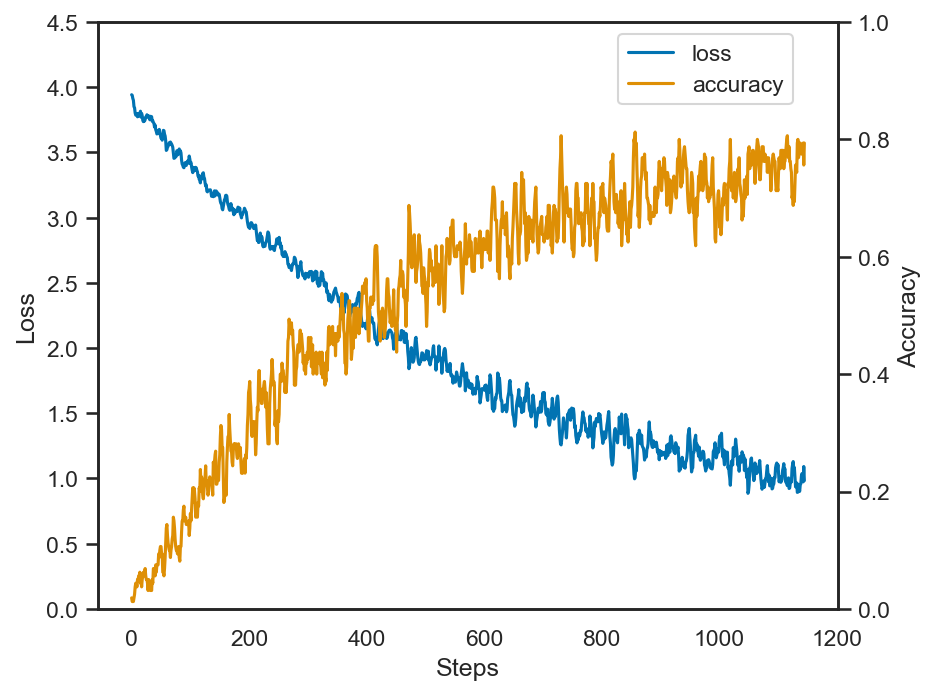

In [57]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(len(losses)), losses, label="loss", color=color_palette[0])
ax1.set_ylim(0.0, 4.5)
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
ax2.plot(np.arange(len(losses)), accuracies, label="accuracy", color=color_palette[1])
ax2.set_ylim(0.0, 1.0)
ax2.set_ylabel("Accuracy")
fig.legend(bbox_to_anchor=(0.85, 0.95))
plt.tight_layout()
plt.show()

In [58]:
pbar = tqdm(test_loader)
n_succ = 0

for data in pbar:
    X, y_true = data
    X = X.reshape((X.size(0), -1))

    model.eval()
    with torch.no_grad():
        y_pred = model(X)

    n_succ += (torch.argmax(y_pred, dim=1) == y_true).float().sum()

total_acc = n_succ / len(test_data)
print(f"Acc: {total_acc:.3f}")

  0%|          | 0/58 [00:00<?, ?it/s]

Acc: 0.707


このように、PyTorchを使ってニューラルネットワークを構築することで、一定の識別精度を得ることができた。

しなしながら、MLPにおいては画像を単純なベクトルとして扱うため、画像の空間的な情報を活かすことが出来ず、その結果はFisherベクトルを用いた場合の精度等には及ばない。

## 畳み込みニューラルネットによる学習

ここまでは、全結合層からなるマルチレイヤ・パーセプトロンによる学習を見てきたが、今回は取り扱う対象が画像であるため、**畳み込みニューラルネット**により、より効果的な学習が期待できる。



全結合層は、入力のベクトルに対して、行列を作用させて、さらにその結果にバイアスベクトルを加算する、というものであった。この操作は、畳み込みニューラルネットで用いられる**畳み込み層**においてもほとんど同じである。

今、入力が画像であり、それが画素ごとに特徴化されて$(H, W, D)$という大きさを持つデータであるとしよう。なお、$H$は画像 (特徴マップ)の高さ、$W$は幅、$D$は各画素が持つ特徴の次元である。

このデータを畳み込み層によって$(W', H', D')$に変換することを考える。畳み込み層が学習可能な重みが畳み込みカーネルを表わす二次元のマップであり、これが$D \times D'$個用意される。カーネルのサイズを$K\times K$とする場合、畳み込み前後の特徴マップのサイズには、

$$
\begin{align}
W' &= W - K + 1 \\
H' &= H - K + 1
\end{align}
$$

という関係がある。また、畳み込み層は、カーネルの大きさに加えて、何画素飛ばしでカーネルを適用するかを表わすストライド$S$と、画像の周りを何らかの値で埋めて、大きさを調整するパディング$P$をパラメータとして持つ。これらの値を加味すると、畳み込み前後の画像サイズの関係は、以下のように書き直せる。

$$
\begin{align}
W' = \frac{H - K + 2P}{S} + 1 \\
H' = \frac{H - K + 2P}{S} + 1
\end{align}
$$

現在は、ニューラルネットワークの畳み込み層で、画像や特徴マップのサイズを変更することは少なく、多くの場合、$P=(K-1)/2$, $S=1$とすることで、畳み込み前後のサイズが変わらないようにすることが多い。例えば、$3\times 3$の畳み込みを用いる場合、$P=1$, $S=1$と設定する。

その代わり、画像や特徴マップのサイズを変更する操作としてプーリングという操作を行なう。プーリングは、$2 \times 2$などの小さな画像領域において、その画素が持つ特徴の最大値や平均を取るような操作を指す。PyTorchにおいては、最大を取る操作が`nn.MaxPool2d`および`F.max_pool2d`に、平均を取る操作が`nn.AvgPool2d`および`F.avg_pool2d`に用意されている。

これらを用いて簡単な畳み込みニューラルネットを実装したものが以下である。

In [59]:
class CNN(nn.Module):
    """
    畳み込みニューラルネット
    """

    def __init__(self, in_channels, out_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 16, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(16)
        self.fc3 = nn.Linear(6 * 6 * 16, out_channels)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # (B, 48, 48 64)
        x = F.max_pool2d(x, 2)  # (B, 24, 24, 64)
        x = torch.relu(self.bn2(self.conv2(x)))  # (B, 24, 24, 32)
        x = F.max_pool2d(x, 2)  # (B, 12, 12, 32)
        x = torch.relu(self.bn3(self.conv3(x)))  # (B, 12, 12, 16)
        x = F.max_pool2d(x, 2)  # (B, 6, 6, 16)
        x = x.reshape((x.size(0), -1))  # (B, 6 * 6 * 16)
        x = self.fc3(x)  # (B, out_channels)
        y = F.log_softmax(x, dim=1)
        return y

ところで、これまで、学習はCPUを用いて計算してきたが、上記の畳み込みニューラルネットになってくると、CPUだけの計算では少々時間がかかるようになってくる。

そこで、GPUが使える環境ではGPUを使うようにデバイスの設定を行なう。GPU上ではNVIDIA社のCUDA (compute unified device architecture)を用いて計算が行なわれ、GPUの性能にもよるが、CPUより遙かに高速な学習が可能である。

CUDAが使えるかどうかの判定には`torch.cuda.is_available()`関数を用いる。

In [60]:
# デバイスの判定
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Your device is", device)

Your device is cpu


デバイスが取得できたら、ネットワークならびに学習データを、デバイスに転送する操作が必要になる。具体的には、それぞれに用意された`to(...)`という関数に対して、上記の`device`インスタンスを指定する。

In [61]:
# ネットワークおよびオプティマイザのインスタンス化
model = CNN(1, n_classes).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1.0e-3)

In [62]:
losses = []
accuracies = []
model.train()
for epoch in range(epochs):
    pbar = tqdm(train_loader)
    for data in pbar:
        # データのデバイスへの転送
        X, y_true = data
        X = X.to(device)
        y_true = y_true.to(device)

        # 推論ならびに損失関数の評価
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        acc = (torch.argmax(y_pred, dim=1) == y_true).float().mean()

        losses.append(loss.item())
        accuracies.append(acc.item())

        pbar.set_description("[CNN] loss={:1.3f}, acc={:1.3f}".format(loss.item(), acc.item()))

        optim.zero_grad()
        loss.backward()
        optim.step()

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

In [63]:
# 移動平均を取る (= ボックス・フィルタをかける)
box_size = 5
box = np.ones((box_size)) / box_size

losses = np.convolve(losses, box, mode="valid")
accuracies = np.convolve(accuracies, box, mode="valid")

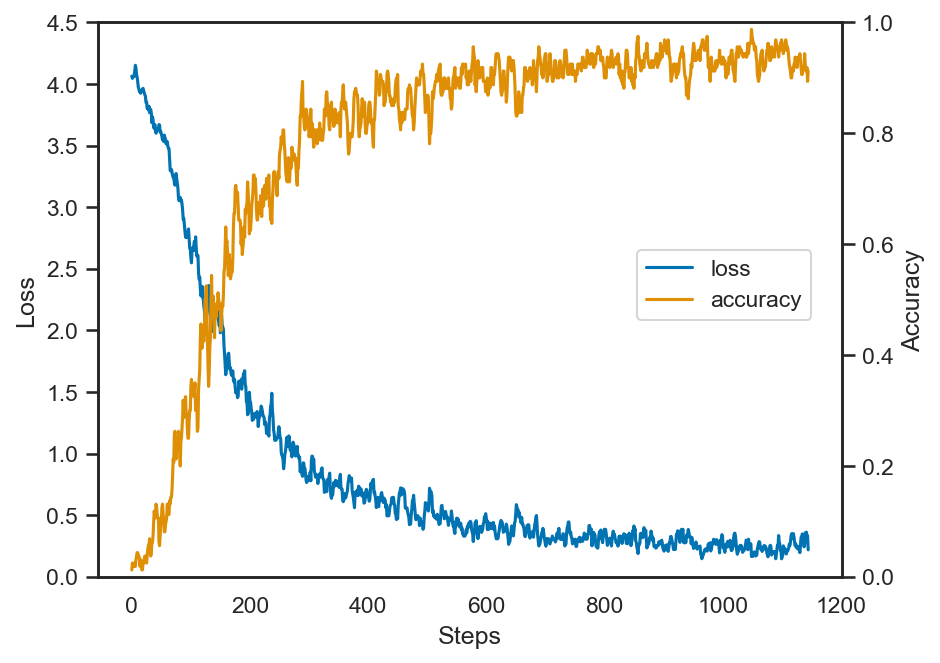

In [64]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(len(losses)), losses, label="loss", color=color_palette[0])
ax1.set_ylim(0.0, 4.5)
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
ax2.plot(np.arange(len(losses)), accuracies, label="accuracy", color=color_palette[1])
ax2.set_ylim(0.0, 1.0)
ax2.set_ylabel("Accuracy")
fig.legend(bbox_to_anchor=(0.88, 0.58))
plt.show()

In [65]:
pbar = tqdm(test_loader)
n_succ = 0

for data in pbar:
    X, y_true = data
    X = X.to(device)
    y_true = y_true.to(device)

    model.eval()
    with torch.no_grad():
        y_pred = model(X)

    n_succ += (torch.argmax(y_pred, dim=1) == y_true).float().sum()

total_acc = n_succ / len(test_data)
print(f"Acc: {total_acc:.3f}")

  0%|          | 0/58 [00:00<?, ?it/s]

Acc: 0.901


このようにCNNを用いて画像としての特徴をより意識するようなニューラルネットワークを用いたことで、識別の精度が大幅に向上したことが分かる。

::::{admonition} 問
:class: question

MLPとCNNを用いた画像識別の各例について、オプティマイザの種類によって、誤差関数の収束と識別精度の上昇がどのように変化するかを調査せよ。

::::

## 学習結果の保存

実際に深層学習をアプリケーションで使う際には、予め時間を掛けてニューラルネットワークを学習しておき、その学習結果だけを読み出して、応用に使用する場合がほとんどだろう。また、途中まで学習がされているネットワークを読み出して、そこから別のデータで**ファイン・チューニング**を行なう場合もあるだろう。

そのような時には、ネットワークのパラメータを`*.pth`ファイルに保存しておくことが一般的である。ネットワークやオプティマイザには、`state_dict()`関数が用意されていて、パラメータとその名前を格納した辞書を取得することができる。このような辞書がネストしたものを`torch.save`関数に渡すことで重みを保存することができる。

In [66]:
ckpt = {
    "model": model.state_dict(),
    "optim": optim.state_dict(),
}
torch.save(ckpt, "ckpt.pth")

このようにして、保存したパラメータは`torch.load`関数で辞書型として読み出すことができ、対応する辞書を`load_state_dict`関数に指定することでパラメータを上書きすることができる。

In [67]:
# ネットワークとオプティマイザの別インスタンスを作成
model2 = CNN(1, n_classes)
model2.to(device)
optim2 = torch.optim.Adam(model2.parameters(), lr=1.0e-3)

# 学習済みパラメータの読み込み
ckpt2 = torch.load("ckpt.pth")
model2.load_state_dict(ckpt2["model"])
optim2.load_state_dict(ckpt2["optim"])

再度、読み込んだパラメータを用いて性能を確認してみる。

In [68]:
pbar = tqdm(test_loader)
n_succ = 0

for data in pbar:
    X, y_true = data
    X = X.to(device)
    y_true = y_true.to(device)

    model2.eval()
    with torch.no_grad():
        y_pred = model2(X)
    n_succ += (torch.argmax(y_pred, dim=1) == y_true).float().sum()

total_acc = n_succ / len(test_data)
print(f"Acc: {total_acc:.3f}")

  0%|          | 0/58 [00:00<?, ?it/s]

Acc: 0.897


このように、パラメータの読み込みにより、以前の結果を再現できていることが分かる。

なお、本項の例は`HiraganaDataset`の内部で画像を読み込むときに**評価時もランダム回転等を適用しているため、実行する度に多少精度が変化する**。

:::{admonition} 異なるデバイスでのパラメータの読み込み
:class: warning

学習を行ったデバイスと異なるデバイスで`.pth`ファイルを読み込む場合、単に `torch.load`を呼び出すだけでは`RuntimeError`になってしまう。

これを防ぐには`torch.load`の引数に`map_location=...`を指定して、どの種類のデバイスに読み込むのかを指定する。例えばCUDA上で学習を行って得たパラメータをCPU上で読み込む場合には、以下のようにすれば良い。

```python
ckpt = torch.load("ckpt.pth", map_location=torch.device("cpu"))
```

:::

(ssec:avoid-overfit)=
## 過学習を防ぐための工夫

上記のCNNによる文字分類の結果を見てみると、訓練時の精度と比較して、テスト時の精度がやや劣っていることが分かる。このような訓練データに対して、過度に高い精度が出てしまう現象を**過学習**と呼ぶ。

過学習を防ぐための方法にはいくつかあるが、主なものとして以下の4つが挙げられる。

- 学習可能なパラメータの数を減らす
- 訓練データ数を増やす
- 正則化項の追加
- ドロップアウトの導入

学習パラメータの数は、過学習の主要な原因の一つで、これはニューラルネットに限らず、モデルが複雑になればなるほど、必要な学習データの数が増す。これは、単純には、連立方程式における制約式の数と未知数の数の関係と同じであり、パラメータ数が多ければ制約を増やす意味で多くの訓練データが必要であり、訓練データの量が十分でないときには、より簡素な機械学習モデルを使う方が過学習の影響を抑えられる。

故に、どのような問題に対しても、**無差別に深層学習を適用すれば良い結果が得られるわけではない**、という点には最大の注意を払ってほしい。やはり、深層学習が発展した今でも、問題に応じて適切な手法を選ばなければならないことに変わりはない。

また、正則化項の導入により過学習を防ぐことも可能である。正則化項とは、非常に大雑把な議論では、各パラメータの絶対値が大きくなりすぎないようにペナルティ項を追加することに対応する。このようなペナルティ項には様々な種類があるが、よく用いられるのはL1正則化、ならびにL2正則化である。L1正則化は学習可能パラメータの絶対値の和を使い、L2正則化は学習可能パラメータの二乗の和を用いる。

PyTorchを用いる場合、L2正則化であれば、オプティマイザをインスタンス化する際に引数として`weight_decay=...`というパラメータを指定することで、正則化がかかる。例えば、

```python
optim = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=1.0e-6)
```

といった感じで、この場合には、パラメータの二乗和に対して`weight_decay=...`で指定した値が乗算されたものが損失関数に追加される。

一方、L1正則化を行ないたい場合には、陽にパラメータの大きさの絶対値の和を足し上げていく必要がある。

In [69]:
# L1正則化の実装例
l1_reg = 0.0
for p in model.parameters():
    l1_reg += p.abs().sum()

最後に紹介するDropoutは、全結合層や畳み込み層中のチャネル間の結びつきをランダムに無効化しながら学習するという仕組みである。例えば、全結合層により、ベクトルの次元数を$D_1$から$D_2$に変える場合、Dropoutされる確率を$p \in (0, 1)$として、$p D_1 D_2$個の行列要素を**訓練時のみ**ランダムに0で埋めてしまう。

こうすることにより、機械学習モデルは、どのパラメータを使った場合にも、まんべんなく訓練データに対する予測ができるように学習が進み、結果として過学習を防ぐことができる。

PyTorchで実装する場合には、活性化関数の後に`nn.Dropout`あるいは`F.dropout`を追加すれば良い。なお、PyTorchの`Dropout`に指定する確率は**パラメータを0で埋める割合**である (つまり`Dropout(p=0.0)`とすると、何もしないことと同義になる)。

::::{admonition} 問
:class: question

[過学習を防ぐための工夫](ssec:avoid-overfit)に示した方法によって、どの程度、過学習が抑制できるかを実際に試してみよ。

::::

:::{admonition} レイヤーの順序
:class: note

現在のニューラルネットワークにおいては、

- 全結合層、畳み込み層などの学習可能な線形操作
- バッチ正規化などのデータ正規化
- 活性化関数
- ドロップアウト

のような順序で演算を行なうことが多いが、この善し悪しについてはあまりはっきりとしないところがある。特に、データ正規化と活性化関数の順序については、その演算の意味を考えると、順序が逆の方が良いと思える部分も多い。

データ正規化の後に活性化関数をもってくる、という順序はバッチ正規化の原論文である{cite}`ioffe2015batch`で提唱された順序であり、多くの手法がこの順序を採用している。しかし、データ正規化がデータの平均を0に合わせることを考えると、その後に、負の値を0で埋めてしまうReLUを適用するのは、やや不適切に思えなくもない。

さらに言えば、データ正規化の効果は全結合層などの線形操作においてバイアスベクトルの学習を促進する効果にあるわけだから、線形操作の直前にデータ正規化が行なわれる方が自然である。

実際、「線形操作」→「活性化関数」→「ドロップアウト」→「データ正規化」の順序の方が性能が向上するという見方もある。このように、論文に書かれていることが常に正しいとは限らないので、論文を読むときには、多少は疑いの目をもって読むことが大事である。
:::

## 参考文献

```{bibliography}
:filter: docname in docnames
```